In [37]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from cycler import cycler

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

import warnings
warnings.simplefilter('ignore', FutureWarning)

## Overview
In the methodology_kmeans.ipynb, all data were standardized and normalized. Therefore, this time, appropriate data preprocessing methods will be executed for each feature based on the suitability of the data. The results will be judged based on the outcomes of k-means.

1. Remove one of the features that have a high correlation coefficient.
2. Look at `df.describe` to try the appropriate data preprocessing method based on the distribution of the data.

The purporse of this notebook is to improve the performance of k-means model.

## Load Data

In [38]:
from utils import get_df_description

# load df
df_train = pd.read_csv('../datasets/df_train.csv')
print(df_train.shape)

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df_train, description_json_df)
df_description

(96096, 26)


,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,frequency,int64,0,Calculated,number of orders
2,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
3,fo_order_id,object,0,df_orders,FK
4,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
5,fo_order_status,object,0,df_orders,
6,fo_order_purchase_timestamp,object,0,df_orders,
7,fo_order_approved_at,object,0,df_orders,
8,fo_order_delivered_carrier_date,object,0,df_orders,
9,fo_order_delivered_customer_date,object,0,df_orders,


In [39]:
## Selecting numeric columns
df_numeric = df_train.select_dtypes(include=['number']).dropna()
df_numeric = df_numeric.drop(columns=['customer_zip_code_prefix']) ## qualitative
print(df_numeric.shape)
df_numeric.head()

(92633, 13)


,frequency,repeater,recency,monetary,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used,customer_in_sao_paulo
0,1,0,160,141.90,0,141.90,1,1,-5.0,5.0,0.0,1,1
1,1,0,163,27.19,0,27.19,1,1,-5.0,4.0,0.0,1,1
2,1,0,585,86.22,1,86.22,1,1,-2.0,3.0,0.0,1,0
3,1,0,369,43.62,1,43.62,1,1,-12.0,4.0,0.0,1,0
4,1,0,336,196.89,1,196.89,1,1,-8.0,5.0,0.0,1,1


In [40]:
# We have rfm_score, so drop frequency and monetary. Also, drop fo_voucher_used because we have fo_voucher_amount
df_numeric = df_numeric.drop(columns=['frequency', 'monetary', 'fo_voucher_used'])

df = df_numeric.sample(n=5000, random_state=42)
# df = df_numeric

print(df.shape)
df.describe()

(5000, 10)


,repeater,recency,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,customer_in_sao_paulo
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,0.035400,288.112200,0.543200,162.116268,0.896000,0.762800,-11.87700,4.129400,3.588004,0.416400
std,0.184807,152.101968,0.643597,234.092944,0.305291,0.425408,10.57797,1.302803,32.426098,0.493011
min,0.000000,49.000000,0.000000,13.780000,0.000000,0.000000,-75.00000,1.000000,0.000000,0.000000
25%,0.000000,164.750000,0.000000,62.597500,1.000000,1.000000,-17.00000,4.000000,0.000000,0.000000
50%,0.000000,271.000000,0.000000,105.490000,1.000000,1.000000,-12.00000,5.000000,0.000000,0.000000
75%,0.000000,397.000000,1.000000,179.340000,1.000000,1.000000,-7.00000,5.000000,0.000000,1.000000
max,1.000000,743.000000,3.000000,6929.310000,1.000000,1.000000,153.00000,5.000000,1201.080000,1.000000


In [41]:
df.skew()

repeater                     5.029957
recency                      0.434739
rfm_score                    0.935514
fo_payment_value             9.898727
fo_is_daytime               -2.595284
fo_is_weekday               -1.236013
fo_delivery_delay_days       2.214884
fo_review_score_mean        -1.433642
fo_voucher_payment_value    23.336440
customer_in_sao_paulo        0.339276
dtype: float64

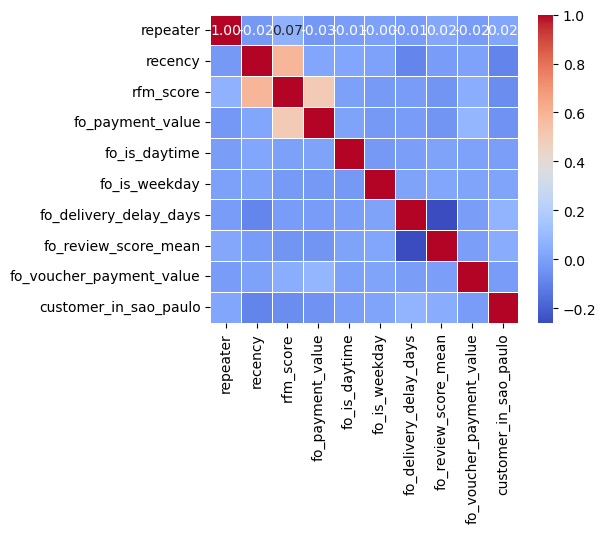

In [42]:
corr = df.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.show()

In [43]:
# Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# robust_yeojohnson_pipeline = Pipeline(steps=[
#     ('robust', RobustScaler()),
#     ('yeojohnson', PowerTransformer(method='yeo-johnson'))
# ])

# Creating a pipeline for applying preprocessing
preprocessors = ColumnTransformer(transformers=[
    ('yeojohnson', PowerTransformer(method='yeo-johnson'), ['fo_delivery_delay_days']),
    ('boxcox', PowerTransformer(method='box-cox'), ['fo_payment_value']),
    ('std', StandardScaler(), ['recency', 'rfm_score', 'fo_review_score_mean']),
    ('robust', RobustScaler(), ['fo_voucher_payment_value']),
    # ('robust_yeojohnson', robust_yeojohnson_pipeline, ['fo_voucher_payment_value']),
])

# Applying the pipeline to the DataFrame
df_transformed = preprocessors.fit_transform(df)

# Adjusting column names in the transformed DataFrame
df_transformed = pd.DataFrame(df_transformed, columns=[
    'fo_delivery_delay_days_yj',
    'fo_payment_value_boxcox',
    'recency_std', 'rfm_score_std', 'fo_review_score_mean_std',
    'fo_voucher_payment_value_robust',
    # 'fo_voucher_payment_value_robust_yj'
])

# Add binary features to the transformed DataFrame
binary_features = ['fo_is_daytime', 'fo_is_weekday']
df_transformed = pd.concat([df_transformed, df[binary_features].reset_index(drop=True)], axis=1)

# Print the skewness of the transformed features
print(df_transformed.skew())

df_transformed.describe()


fo_delivery_delay_days_yj            -0.641983
fo_payment_value_boxcox               0.006210
recency_std                           0.434739
rfm_score_std                         0.935514
fo_review_score_mean_std             -1.433642
fo_voucher_payment_value_robust_yj    4.952274
dtype: float64


,fo_delivery_delay_days_yj,fo_payment_value_boxcox,recency_std,rfm_score_std,fo_review_score_mean_std,fo_voucher_payment_value_robust_yj
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,1.296740e-16,1.875833e-16,1.755041e-16,-1.847411e-17,-3.190337e-16,8.526513e-18
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00
min,-8.312744e+00,-3.228736e+00,-1.572209e+00,-8.440913e-01,-2.402292e+00,-1.943579e-01
25%,-4.881090e-01,-6.682873e-01,-8.111305e-01,-8.440913e-01,-9.933425e-02,-1.943579e-01
50%,7.916342e-02,3.706161e-02,-1.125160e-01,-8.440913e-01,6.683184e-01,-1.943579e-01
75%,6.108645e-01,6.769711e-01,7.159585e-01,7.098323e-01,6.683184e-01,-1.943579e-01
max,6.985457e+00,3.548999e+00,2.990976e+00,3.817680e+00,6.683184e-01,5.145188e+00


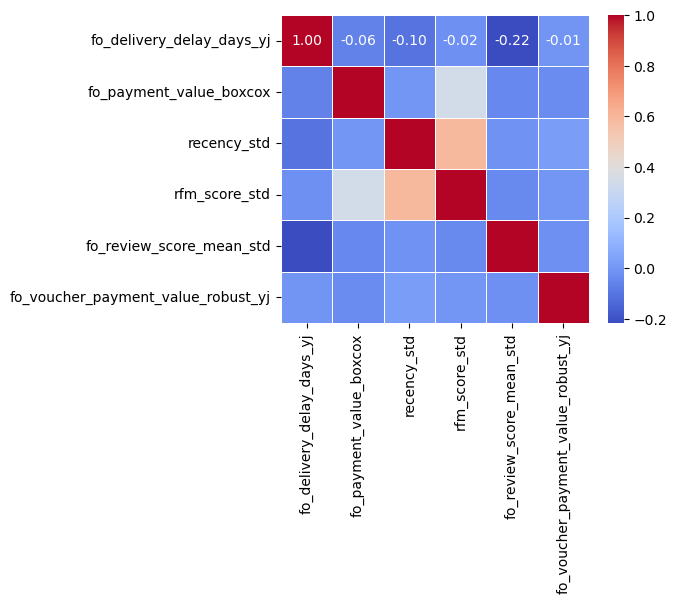

In [44]:
corr = df_transformed.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.show()

## k-means

In [45]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans

def find_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []
    dbi_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        s_score = silhouette_score(data, labels)
        dbi_score = davies_bouldin_score(data, labels)
        silhouette_scores.append(s_score)
        dbi_scores.append(dbi_score)
        print(n_clusters, s_score, dbi_score)

    # Returning all silhouette and DBI scores
    return silhouette_scores, dbi_scores

2 0.2819863848965093 1.5503207686306042
3 0.3130615047192028 1.187590086571978
4 0.33054830197221163 1.1072697364320796
5 0.34450238435828734 1.044691315971642
6 0.2765423571892265 1.1559622732642
7 0.24185345228418845 1.2955499826373846
8 0.24827920472640463 1.223345689195883
9 0.25678452570264665 1.2336494695916995
10 0.2613435452879048 1.1890571847897982


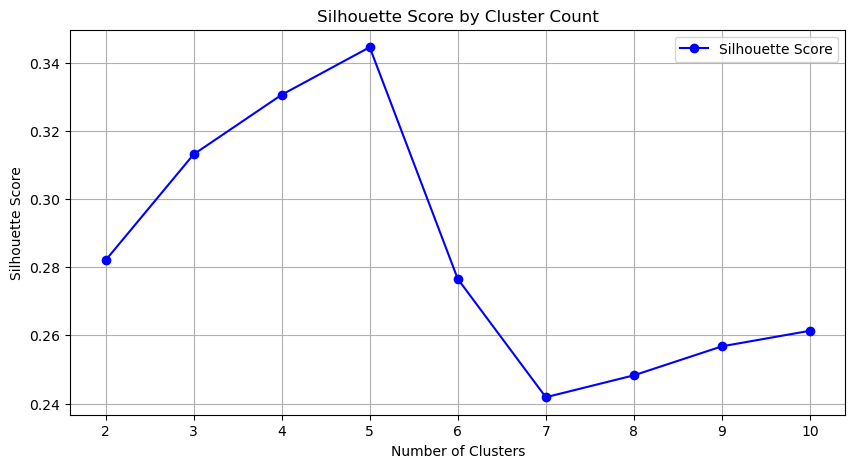

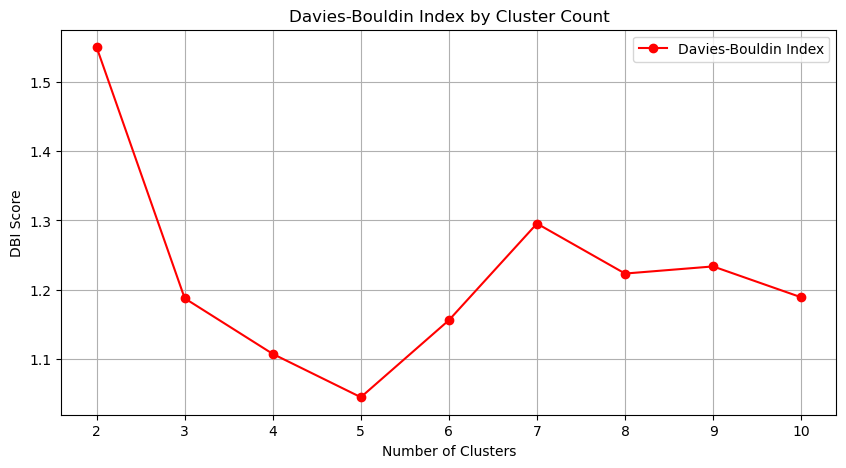

In [46]:
silhouette_scores, dbi_scores = find_optimal_clusters(df_transformed, max_clusters=10)

clusters_range = range(2, 11)

plt.figure(figsize=(10, 5))
plt.plot(clusters_range, silhouette_scores, marker='o', linestyle='-', color='blue', label='Silhouette Score')
plt.title('Silhouette Score by Cluster Count')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(clusters_range)
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.plot(clusters_range, dbi_scores, marker='o', linestyle='-', color='red', label='Davies-Bouldin Index')
plt.title('Davies-Bouldin Index by Cluster Count')
plt.xlabel('Number of Clusters')
plt.ylabel('DBI Score')
plt.xticks(clusters_range)
plt.legend()
plt.grid(True)

plt.show()

In [47]:
# Cluster the data
kmeans = KMeans(n_clusters=5, random_state=42)
df_transformed['cluster'] = kmeans.fit_predict(df_transformed)

cluster_1 = df_transformed[df_transformed['cluster'] == 0]
cluster_2 = df_transformed[df_transformed['cluster'] == 1]
cluster_3 = df_transformed[df_transformed['cluster'] == 2]
cluster_4 = df_transformed[df_transformed['cluster'] == 3]
cluster_5 = df_transformed[df_transformed['cluster'] == 4]

print(cluster_1.shape, cluster_2.shape, cluster_3.shape, cluster_4.shape, cluster_5.shape)

(636, 7) (1668, 7) (327, 7) (182, 7) (2187, 7)


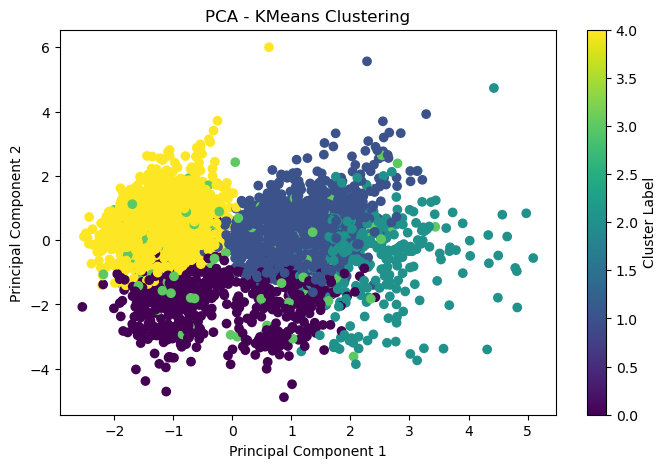

In [48]:
# using PCA and plot the result
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_transformed.drop(columns='cluster'))

plt.figure(figsize=(8, 5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title('PCA - KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()
